# M5 Data Pre-Processing and Prelininary Modeling 

In [1]:
import itertools
import pandas as pd
import numpy as np
import pmdarima
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pmdarima import auto_arima
from pathlib import Path
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

# Data Structure for Time Series

In [2]:
clean_data = Path(r"C:\Users\brian\Desktop\Time Series Predict Unit Sales for Walmart\Clean Dataset")

file_in = clean_data / "data.parquet"
# Read the parquet file
CA_3 = pd.read_parquet(path=file_in, engine="pyarrow", filters=[("store_id", "=", "CA_3")], use_legacy_dataset=False)

# Convert the 'date' column to datetime type
CA_3['date'] = pd.to_datetime(CA_3['date'])

In [3]:
CA_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832737 entries, 0 to 5832736
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   state_id      category      
 5   day           object        
 6   units_sold    int64         
 7   date          datetime64[ns]
 8   weekday       category      
 9   event_name_1  category      
 10  event_type_1  category      
 11  event_name_2  category      
 12  event_type_2  category      
 13  snap_CA       uint8         
 14  snap_TX       uint8         
 15  snap_WI       uint8         
 16  sell_price    float64       
 17  store_id      category      
dtypes: category(11), datetime64[ns](1), float64(1), int64(1), object(1), uint8(3)
memory usage: 268.3+ MB


In [4]:
CA_3.head(5)

,id,item_id,dept_id,cat_id,state_id,day,units_sold,date,weekday,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,store_id
0,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_1,1,2011-01-29,Saturday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0,CA_3
1,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_2,2,2011-01-30,Sunday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0,CA_3
2,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_3,1,2011-01-31,Monday,no_promo,no_promo,no_promo,no_promo,0,0,0,2.0,CA_3
3,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_4,1,2011-02-01,Tuesday,no_promo,no_promo,no_promo,no_promo,1,1,0,2.0,CA_3
4,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA,d_5,1,2011-02-02,Wednesday,no_promo,no_promo,no_promo,no_promo,1,0,1,2.0,CA_3


In [5]:
CA_3.isnull().sum()

id              0
item_id         0
dept_id         0
cat_id          0
state_id        0
day             0
units_sold      0
date            0
weekday         0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
sell_price      0
store_id        0
dtype: int64

In [6]:
CA_3 = CA_3.groupby('date').sum()

In [7]:
CA_3 = CA_3.resample(rule='D').sum()

In [8]:
df = CA_3[['units_sold']]

<AxesSubplot:xlabel='date'>

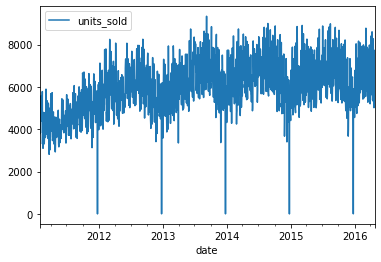

In [9]:
df.plot()

# Train Test Split

In [10]:
train_start = '2011-01-29'
train_end = '2014-06-30'

val_start = '2014-07-01'
val_end = '2015-06-30'

test_start = '2015-07-01'
test_end = '2016-04-24'

In [11]:
train_target = df.loc[train_start:train_end]
validation_target = df.loc[val_start:val_end]
test_target = df.loc[test_start:test_end]

# Naive  

In [12]:
# Implement the naive approach
def naive_forecast(data):
    return data.iloc[-1]  # Return the last observed value

# Apply the naive forecast to the entire validation set
naive_prediction = naive_forecast(train_target)

# Create an array of the naive prediction with the same length as the validation set
naive_forecast_validation = np.array([naive_prediction] * len(validation_target))

# Create an array of true values with the same length as the forecast, filled with the first observed value
y_true = validation_target.values


In [13]:
# Calculate Mean Absolute Percentage Error (MAPE) for the validation set
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape_validation = mean_absolute_percentage_error(y_true, naive_forecast_validation)
print("MAPE on Validation Set:", mape_validation)

MAPE on Validation Set: 14.573160894699285


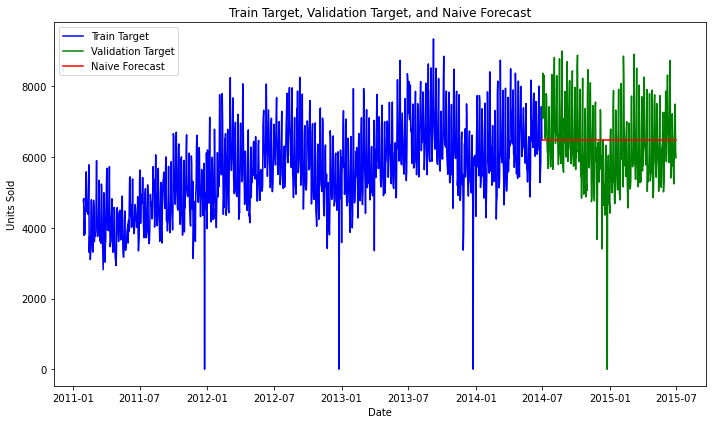

In [14]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train_target in blue
ax.plot(train_target.index, train_target['units_sold'], label='Train Target', color='blue')

# Plot validation_target in green
ax.plot(validation_target.index, validation_target['units_sold'], label='Validation Target', color='green')

# Plot the naive forecast (prediction) in red
ax.plot(validation_target.index, naive_forecast_validation, label='Naive Forecast', color='red')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Train Target, Validation Target, and Naive Forecast')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Mean

In [15]:
def mean_forecast(historical_data):
    n = len(historical_data)
    if n == 0:
        raise ValueError("Historical data is empty, cannot calculate mean forecast.")
    
    mean_forecast = sum(historical_data) / n
    return mean_forecast

In [16]:
base_mean = mean_forecast(train_target['units_sold'])

In [17]:
base_mean

5615.48839071257

In [18]:
# Create an array of the mean prediction with the same length as the validation set
mean_forecast_validation = np.array([[base_mean] for _ in range(len(validation_target))])

In [19]:
mape_validation_mean = mean_absolute_percentage_error(y_true, mean_forecast_validation)
print("MAPE on Validation Set:", mape_validation_mean)

MAPE on Validation Set: 13.8967991501678


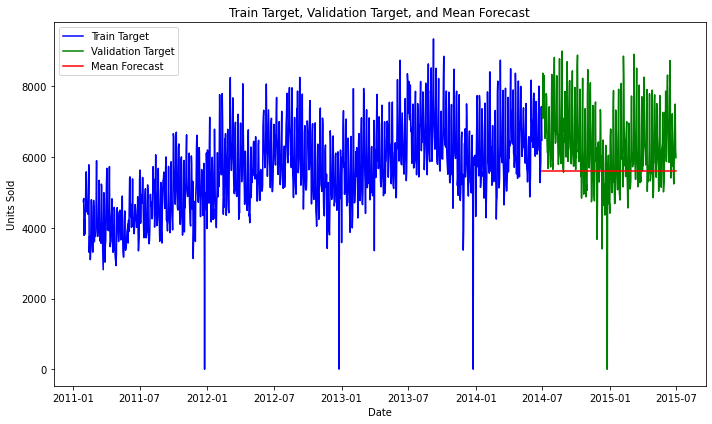

In [20]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train_target in blue
ax.plot(train_target.index, train_target['units_sold'], label='Train Target', color='blue')

# Plot validation_target in green
ax.plot(validation_target.index, validation_target['units_sold'], label='Validation Target', color='green')

# Plot the mean forecast (prediction) in red
ax.plot(validation_target.index, mean_forecast_validation, label='Mean Forecast', color='red')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Train Target, Validation Target, and Mean Forecast')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Seasonal Naive

In [21]:
def seasonal_naive_forecast(train_data, validation_data, seasonality): 
 
    seasonal_naive_forecast = []
    for i in range(len(validation_data)):
        # Find the corresponding observation from the previous year at the same seasonality index
        prev_year_index = i % seasonality
        prev_year_observation = train_data.iloc[-seasonality + prev_year_index]['units_sold']
        
        # Append the previous year's observation to the forecast
        seasonal_naive_forecast.append(prev_year_observation)
    
    # Convert the forecast to a pandas Series with the 'date' index from validation_data
    forecasted_values = pd.Series(seasonal_naive_forecast, index=validation_data.index)
    
    return forecasted_values

In [22]:
# Define the seasonality (e.g., 7 for weekly, 12 for monthly, 365 for yearly)
seasonality = 7

# Get the seasonal naive forecast for the validation set
seasonal_naive_pred = seasonal_naive_forecast(train_target, validation_target, seasonality)

In [23]:
def seasonal_naive_forecast(train_data, validation_data, seasonality):
    
    # Calculate the seasonal naive forecast for the validation period
    seasonal_naive_forecast = []
    for i in range(len(validation_data)):
        # Find the corresponding observation from the previous year at the same seasonality index
        prev_year_index = i % seasonality
        prev_year_observation = train_data.iloc[-seasonality + prev_year_index]['units_sold']
        
        # Append the previous year's observation to the forecast
        seasonal_naive_forecast.append(prev_year_observation)
    
    # Convert the forecast to a numpy array 
    forecasted_values = np.array(seasonal_naive_forecast).reshape(-1, 1)
    
    return forecasted_values

In [24]:
# Define the seasonality (e.g., 7 for weekly, 12 for monthly, 365 for yearly)
seasonality = 7

# Get the seasonal naive forecast for the validation set
seasonal_naive_pred = seasonal_naive_forecast(train_target, validation_target, seasonality)

In [25]:
mape_validation_SNAIVE = mean_absolute_percentage_error(y_true, seasonal_naive_pred)
print("MAPE on Validation Set:", mape_validation_SNAIVE)

MAPE on Validation Set: 9.050120883845675


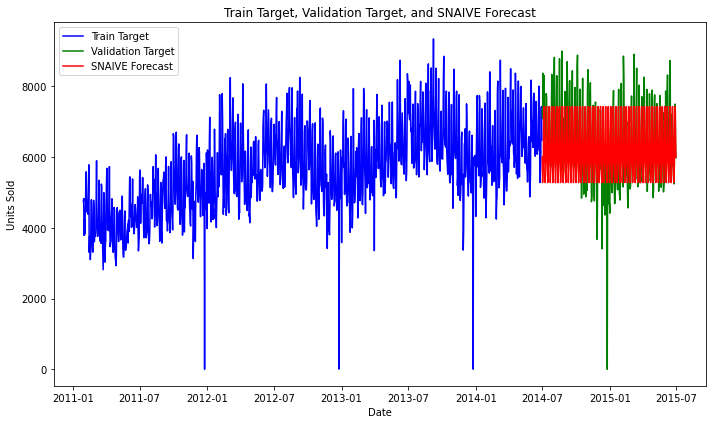

In [26]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train_target in blue
ax.plot(train_target.index, train_target['units_sold'], label='Train Target', color='blue')

# Plot validation_target in green
ax.plot(validation_target.index, validation_target['units_sold'], label='Validation Target', color='green')

# Plot the SNAIVE forecast (prediction) in red
ax.plot(validation_target.index, seasonal_naive_pred, label='SNAIVE Forecast', color='red')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Train Target, Validation Target, and SNAIVE Forecast')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Holt Winters Method

In [27]:
HW_model = ExponentialSmoothing(train_target, trend='mul', seasonal='add', seasonal_periods=7).fit()

C:\Users\brian\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [28]:
HW_Test_pred = HW_model.predict(start=len(train_target), end=len(train_target) + len(validation_target) - 1)

In [29]:
HW_Test_pred

2014-07-01    5843.836871
2014-07-02    5532.563870
2014-07-03    5640.439830
2014-07-04    5978.297888
2014-07-05    7221.271764
                 ...     
2015-06-26    5792.405966
2015-06-27    7035.395139
2015-06-28    7436.482086
2015-06-29    6198.182481
2015-06-30    5654.307538
Freq: D, Length: 365, dtype: float64

In [30]:
HW_forecasted_values = np.array(HW_Test_pred).reshape(-1, 1)

In [31]:
mape_validation_HW = mean_absolute_percentage_error(y_true, HW_forecasted_values)
print("MAPE on Validation Set:", mape_validation_HW)

MAPE on Validation Set: 8.502378109683496


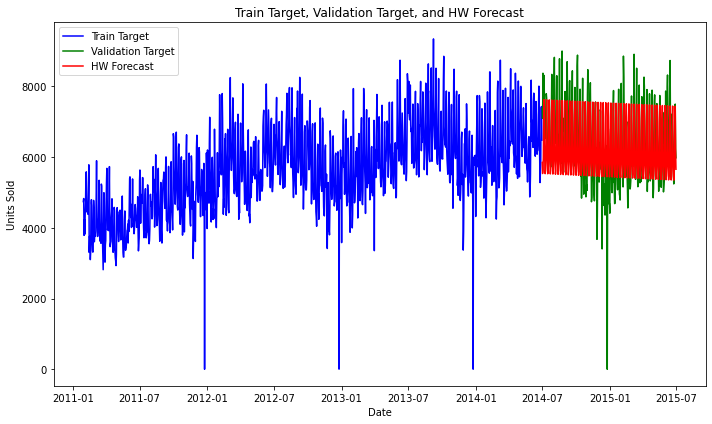

In [32]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train_target in blue
ax.plot(train_target.index, train_target['units_sold'], label='Train Target', color='blue')

# Plot validation_target in green
ax.plot(validation_target.index, validation_target['units_sold'], label='Validation Target', color='green')

# Plot the Holt Winters forecast (prediction) in red
ax.plot(validation_target.index, HW_Test_pred, label='HW Forecast', color='red')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Train Target, Validation Target, and HW Forecast')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


Based on seasonal decomposition in EDA, the trend appears to be multiplicative, and the seasonal component appears to be additive. I tested every combination in this model just to verify. The lowest MAPE score was obtained with trend='mul' and seasonal='add'.

# ARIMA

<span style="font-size: 18px;"> Hyperparameter tuning option 1: using a custom for loop to find best hyperparameters based on RMSE<span>

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
train_target[train_target['units_sold'] < 100]

,units_sold
date,
2011-12-25,1
2012-12-25,4
2013-12-25,3


In [35]:
validation_target[validation_target['units_sold'] < 100]

,units_sold
date,
2014-12-25,0


In [36]:
# Update the units sold for 2014-12-25 to LY=3
validation_target.loc['2014-12-25', 'units_sold'] = 3

In [37]:
p = range(0,8)
d = range(1,2)
q = range(0,8)

In [38]:
pdq_combo = list(itertools.product(p,d,q))

In [39]:
len(pdq_combo)

64

In [40]:
rmse=[]
order1=[]

In [41]:
# create a list of parameter combos with RMSE scores
for pdq in pdq_combo:
    try:
        model = ARIMA(train_target, order=pdq).fit()
        pred = model.predict(start=validation_target.index[0], end=validation_target.index[-1])
        error = np.sqrt(mean_squared_error(validation_target, pred))
        order1.append(pdq)
        rmse.append(error)
    except:
        continue

In [42]:
results = pd.DataFrame(index=order1, data=rmse, columns=['RMSE'])

In [43]:
min_rmse_index = results['RMSE'].idxmin()
min_rmse_value = results['RMSE'].min()

print("Index of the minimum RMSE value:", min_rmse_index)
print("Minimum RMSE value:", min_rmse_value)

Index of the minimum RMSE value: (6, 1, 6)
Minimum RMSE value: 762.5067619096308


In [44]:
ARIMA1_model =ARIMA(train_target, order=(6,1,6)).fit()

In [45]:
ARIMA_pred = ARIMA1_model.predict(start=validation_target.index[0], end=validation_target.index[-1])

In [46]:
ARIMA1_RMSE = np.sqrt(mean_squared_error(validation_target, ARIMA_pred))
ARIMA1_RMSE

762.5067619096308

 RMSE indicates that the average prediction error of the model is around 762 units_sold.

In [47]:
ARIMA_forecasted_values = np.array(ARIMA_pred).reshape(-1, 1)

In [48]:
mape_validation_ARIMA = mean_absolute_percentage_error(y_true, ARIMA_forecasted_values)
print("MAPE on Validation Set:", mape_validation_ARIMA)

MAPE on Validation Set: 521.5685675366536


In [49]:
validation_target.mean(), np.sqrt(validation_target.var())

(units_sold    6292.452055
 dtype: float64,
 units_sold    1093.692649
 dtype: float64)

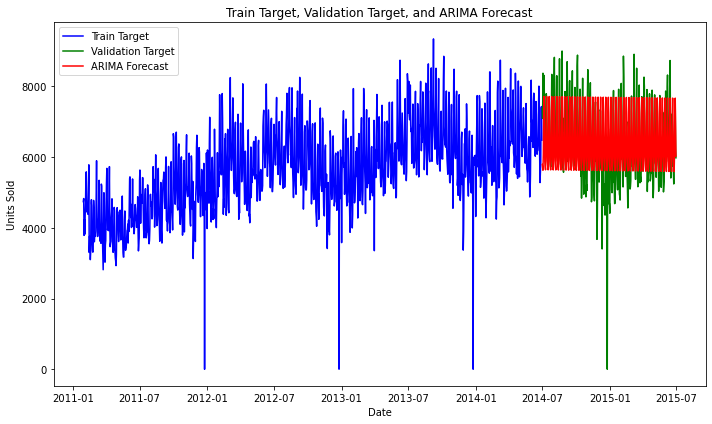

In [50]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train_target in blue
ax.plot(train_target.index, train_target['units_sold'], label='Train Target', color='blue')

# Plot validation_target in green
ax.plot(validation_target.index, validation_target['units_sold'], label='Validation Target', color='green')

# Plot the ARIMA (prediction) in red
ax.plot(validation_target.index, ARIMA_pred, label='ARIMA Forecast', color='red')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Train Target, Validation Target, and ARIMA Forecast')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

<span style="font-size: 18px;"> Hyperparameter tuning option 2: AutoARIMA<span>

In [51]:
auto_arima(train_target, m=7, start_P=0, seasonal=True, d=1, trace=True, error_action= 'ignore', supress_warnings= True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=19913.667, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=20519.807, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=20006.949, Time=0.65 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=20205.432, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=20517.811, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=19920.981, Time=1.13 sec
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=19829.119, Time=3.69 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=4.65 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=19821.252, Time=2.60 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=19889.635, Time=1.87 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=4.20 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=19858.278, Time=2.91 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=1

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 2, 7),
      suppress_warnings=True)

In [54]:
order = (0,1,3)  # Obtained from auto_arima
seasonal_order = (0,0,2,7)

In [55]:
sarima_model = sm.tsa.statespace.SARIMAX(train_target, order=order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()

In [56]:
sarima_pred = sarima_fit.predict(start=validation_target.index[0], end=validation_target.index[-1], dynamic=False)

In [57]:
sarima_RMSE = np.sqrt(mean_squared_error(validation_target, sarima_pred))
sarima_RMSE

1108.8422578909642

In [58]:
SARIMA_forecasted_values = np.array(sarima_pred ).reshape(-1, 1)

In [59]:
mape_validation_SARIMA = mean_absolute_percentage_error(y_true, SARIMA_forecasted_values)
print("MAPE on Validation Set:", mape_validation_SARIMA)

MAPE on Validation Set: 605.4862668327646


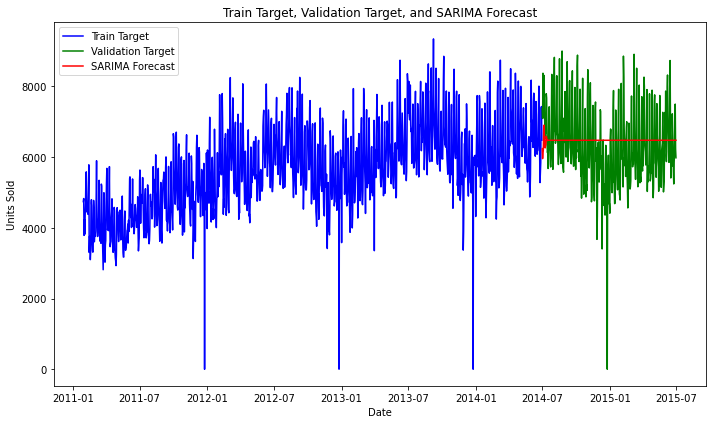

In [60]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train_target in blue
ax.plot(train_target.index, train_target['units_sold'], label='Train Target', color='blue')

# Plot validation_target in green
ax.plot(validation_target.index, validation_target['units_sold'], label='Validation Target', color='green')

# Plot the SARIMA (prediction) in red
ax.plot(validation_target.index, sarima_pred, label='SARIMA Forecast', color='red')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Units Sold')
ax.set_title('Train Target, Validation Target, and SARIMA Forecast')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()